In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as c
from matplotlib import rcParams
import sympy as sy
import scipy.constants as pc
from sympy import *
from math import log10, floor

rcParams['font.size'] = 16
rcParams['font.weight'] = 'bold'
rcParams['text.usetex'] = True
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Helvetica']

In [2]:
# Funktionen
def am(werte):
    return np.mean(werte)

def std(werte):
    summen_der_quadrate = 0
    for wert in werte:
        summen_der_quadrate+=(wert-am(werte))**2       
    return np.sqrt(summen_der_quadrate/(werte.size-1))

def stu(werte):
    return std(werte)/np.sqrt(werte.size)

def fehler(f, werte, unsicherheiten, variablen):
    zMax = 0
    for i in range(werte.size):
        dif = np.abs(sy.diff(f, variablen[i]))
        zMax += (dif * unsicherheiten[i])**2
    zMax = sqrt(zMax)
    for j in range(werte.size):
        zMax = sub(zMax, variablen[j], werte[j])
    return zMax

def fehlerMax(f, werte, unsicherheiten, variablen):
    zMax = 0
    for i in range(werte.size):
        dif = np.abs(sy.diff(f, variablen[i]))
        zMax += dif * unsicherheiten[i]
    for j in range(werte.size):
        zMax = sub(zMax, variablen[j], werte[j])
    return zMax

def groessterBeitrag(f, werte, unsicherheiten, variablen):
    zMax = 0
    zMaxArray = np.array([])
    for i in range (werte.size):
        zMax = (np.abs(sy.diff(f, variablen[i])) * unsicherheiten[i])
        for j in range(werte.size):
            zMax = sub(zMax, variablen[j], werte[j])
        x = np.array([zMax])
        zMaxArray = np.append(zMaxArray, x)
    return variablen[np.argmax(zMaxArray)], zMaxArray[np.argmax(zMaxArray)]

def sub(zMax, variable, wert):
    return zMax.subs([(variable, wert)])

def einfachGaussAdd(unsicherheiten, koeffizienten):
    dz = 0
    for i in range (unsicherheiten.size):
        dz += (koeffizienten[i]*unsicherheiten[i])**2
    return sqrt(dz)

def einfachGaussMult(unsicherheiten, werte, exponenten):
    dz = 0
    for i in range (unsicherheiten.size):
        dz += (exponenten[i]*unsicherheiten[i]/werte[i])**2
    return sqrt(dz)

def einfachGaussMultMax(unsicherheiten, werte, exponenten):
    max_a = 0
    num = -1
    for i in range (unsicherheiten.size):
        maxi = (exponenten[i]*unsicherheiten[i]/werte[i])**2
        if max_a <= maxi:
            max_a = maxi
            num = i
    return (max_a, num)

def vertraeglichkeit(am_1, am_2, stu_1, stu_2):
    return (np.abs(am_1-am_2)/(sqrt((stu_1**2)*(stu_2**2))))

def bestA(x, y):
    return (sum(x**2)*sum(y)-sum(x)*sum(x*y))/(x.size*sum(x**2)-sum(x)**2)

def bestB(x, y):
    return (x.size*sum(x*y)-sum(x)*sum(y))/(x.size*sum(x**2)-sum(x)**2)

def streuung(x, y):
    s = 0
    for i in range(x.size):
        s += (y[i]-(bestA(x, y)+bestB(x, y)*x[i]))**2
    return np.sqrt(s/(x.size-2))

def stuA(x, y):
    s = streuung(x, y)
    return s*np.sqrt(sum(x**2)/((x.size*sum(x**2)-sum(x)**2)))

def stuB(x, y):
    s = streuung(x, y)
    return s*np.sqrt(x.size/((x.size*sum(x**2)-sum(x)**2)))

def round_to_j(x,j):
    return round(x, (j-1)-int(floor(log10(abs(x)))))

def print_to_table(avgs, stds, rows, cols,
                   highlight_best=True,
                   max_is_best=True,
                   avg_format='{0:!>4.1f}',
                   std_format='{1:!<4.1f}',
                   file=None,
                   col_orientation='c'):
    # Find best values
    best_avg = {}
    if highlight_best:
        if max_is_best:
            for c in cols:
                idx = np.argmax(avgs[c], axis=0)
                best_avg[c] = idx
        else:
            for c in cols:
                idx = np.argmin(avgs[c], axis=0)
                best_avg[c] = idx

    # Header
    print_str = '\\begin{tabular}{l' + (" "+col_orientation) * len(cols) + '} \hline\n'
    for c in cols:
        print_str += ' & ' + c
    print_str += ' \\\\ \n \hline'

    # Content
    for m in range(len(rows)):
        row_name = rows[m]
        print_str += '\n{0}'.format(row_name)
        for c in cols:
            print_str += ' &\n '
            print_list = [avgs[c][m]]
            print_list += [stds[c][m]]
            if m == best_avg.get(c, None):
                print_str += ('$\mathbf{{'+ avg_format + ' \\pm ' + std_format + '}}$').format(*print_list)
            else:
                print_str += ('$'+ avg_format + ' \\pm ' + std_format + '$').format(*print_list)

        print_str += "\n \\vspace*{0.0mm} \\\\"
        print_str = print_str.replace('!', '\\phantom{0}')

    # Footer
    print_str += '\n \hline \n \end{tabular}'

    # Write output
    if file is None:
        print(print_str)
    else:
        with open(file, 'w') as f:
            f.write(print_str)
            
            
def txtToArr(name):
    with open(name) as f:
        l = f.readlines()
    
    del l[0]

    time_arr = np.array([])
    temp_arr = np.array([])

    for el in l:
        el_changed = l[l.index(el)].replace(',', '.') 
        l[l.index(el)] = el_changed.split()
        el_changed = el_changed.split()
        time_arr = np.append(time_arr, float(el_changed[0]))
        temp_arr = np.append(temp_arr, float(el_changed[1]))
    
    return time_arr, temp_arrx

In [3]:
# Erinnerungen
# x = np.array([,])kid amogus
# x.size
# x, y = symbols('x y')
# expr = x*y
# expr.subs([(x, wert_x), (y, wert_y)])

In [7]:
# Messung mechanisch
temp_m  = np.array([21.7, 22.5, 23.5, 24.4, 25.4, 26.3, 27.3, 28.1, 29.1, 30.0, 30.9, 
                    31.9, 32.7, 33.6, 34.5, 35.4, 36.3, 37.0, 37.8, 38.6, 39.4])
temp_m_f = 0.1

u_m = np.linspace(0, 1000, 21)
u_m_f = 0.0

t_m = np.array([0, 180, 360, 540, 720])
temp_m_a = np.array([38.9, 37.8, 36.7, 35.7, 34.3])

d_zyl = 0.0455
d_zyl_f = 0.006

#t_150_vl= max(temp_e_150)+

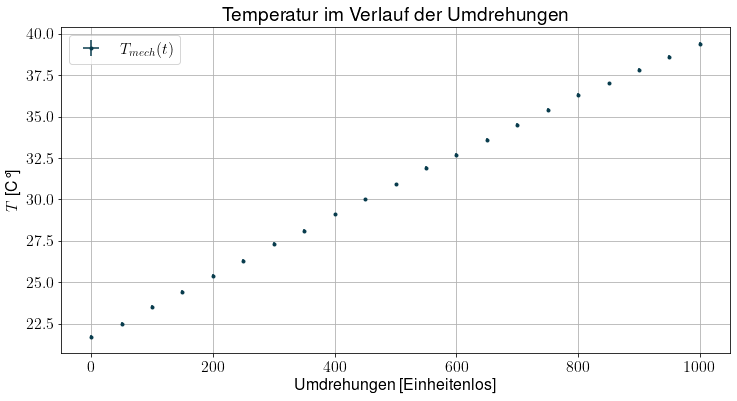

In [8]:
fig, ax = plt.subplots(figsize=(12,6))
#ax.tick_params(axis='both', which='major', labelsize=18)
#ax.tick_params(axis='both', which='minor', labelsize=16)

#ax.plot(x, y, color='b', label='label')
#ax.scatter(x, y, color='r', label='label')

ax.errorbar(u_m, temp_m, xerr=u_m_f, yerr=temp_m_f, fmt='.', color='#073b4c', label=r'$T_{mech}(t)$')

ax.set(xlabel=r'Umdrehungen [Einheitenlos]', ylabel=r'$T$ [C°]', title=r'Temperatur im Verlauf der Umdrehungen')
ax.legend()
ax.grid()

#fig.savefig("Tmech.svg")

In [9]:
temp_m_d = np.diff(temp_m)#max(temp_m)-min(temp_m)

cap_band = 5 # J/K
s_cap_cu = 380 # J/kgK
m_cal = 0.16654 # kg
m_cal_w = 0.23123 # kg
m_w = m_cal_w-m_cal
m_w_f = 0.001 # kg
m_cal_f = 0.001 # kg
cap_cal = s_cap_cu*m_cal

w_r = 5*pc.g*50*pc.pi*d_zyl

w_m = ((w_r/temp_m_d)-cap_band-cap_cal)/(m_w)

print(w_m)

print(am(w_m))
print(stu(w_m))



[5716.07904831 4361.74807402 4963.67295148 4361.74807402 4963.67295148
 4361.74807402 5716.07904831 4361.74807402 4963.67295148 4963.67295148
 4361.74807402 5716.07904831 4963.67295148 4963.67295148 4963.67295148
 4963.67295148 6683.45831566 5716.07904831 5716.07904831 5716.07904831]
5124.90282937373
141.84885976372863


In [15]:
# Messung elektrisch
temp_e_150 = np.array([38, 39, 42, 45, 53, 57, 61, 65])
t_e_150 = np.array([0, 30, 60, 90, 150, 180, 210, 240])

temp_e_150_s = np.array([39, 42, 45])
t_e_150_s = np.array([30, 60, 90])

temp_e_170  = np.array([21, 23, 26, 30, 33, 36, 39, 42, 46])
t_e_170 = np.array([0, 30, 60, 105, 120, 150, 180, 210, 240])

temp_e_170_s  = np.array([23, 26, 30, 33])
t_e_170_s = np.array([30, 60, 105, 120])

temp_e_190  = np.array([20, 22, 25, 28, 30, 34, 37, 40, 42])
t_e_190 = np.array([0, 30, 60, 90, 120, 150, 180, 210, 240])

temp_e_190_s  = np.array([22, 25, 28, 30])
t_e_190_s = np.array([30, 60, 90, 120])

temp_e_210  = np.array([20, 22, 24, 27, 30, 32, 35, 38, 41])
t_e_210 = np.array([0, 30, 60, 90, 120, 150, 180, 210, 240])

temp_e_210_s  = np.array([22, 24, 27, 30])
t_e_210_s = np.array([30, 60, 90, 120])

temp_e_230  = np.array([20, 21, 24, 26, 29, 32, 34, 38, 39])
t_e_230 = np.array([0, 30, 60, 90, 120, 150, 180, 210, 240])

temp_e_230_s  = np.array([21, 24, 26, 29])
t_e_230_s = np.array([30, 60, 90, 120])
t_m_f  = 0.1

-2.411111111111097


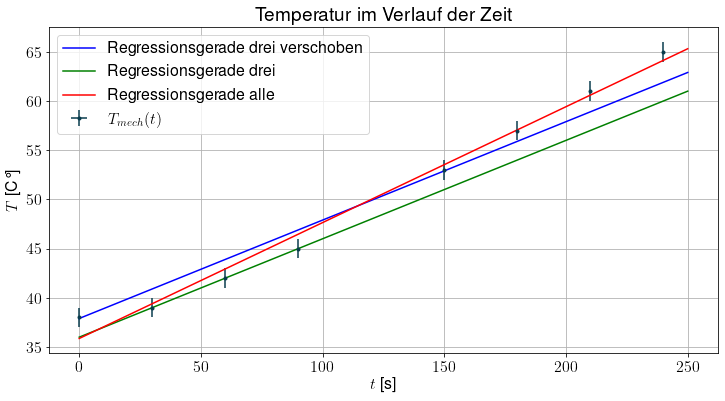

In [16]:
fig, ax = plt.subplots(figsize=(12,6))
#ax.tick_params(axis='both', which='major', labelsize=18)
#ax.tick_params(axis='both', which='minor', labelsize=16)

#ax.plot(x, y, color='b', label='label')
#ax.scatter(x, y, color='r', label='label')

x = np.linspace(0, 250, 500)
a, b = bestA(t_e_150_s, temp_e_150_s), bestB(t_e_150_s, temp_e_150_s)

ax.errorbar(t_e_150, temp_e_150, xerr=t_m_f, yerr=temp_m_f, fmt='.', color='#073b4c', label=r'$T_{mech}(t)$')

ax.plot(x, b*(x+19)+a, color='b', label='Regressionsgerade drei verschoben')
ax.plot(x, b*(x)+a, color='g', label='Regressionsgerade drei')

a2, b2 = bestA(t_e_150, temp_e_150), bestB(t_e_150, temp_e_150)
ax.plot(x, b2*(x)+a2, color='r', label='Regressionsgerade alle')

ax.set(xlabel=r'$t$ [s]', ylabel=r'$T$ [C°]', title=r'Temperatur im Verlauf der Zeit')
ax.legend()
ax.grid()

fig.savefig("Tel150.svg")

print((b*(max(x)+19)+a)-(b2*(max(x))+a2))

1.106334316090411


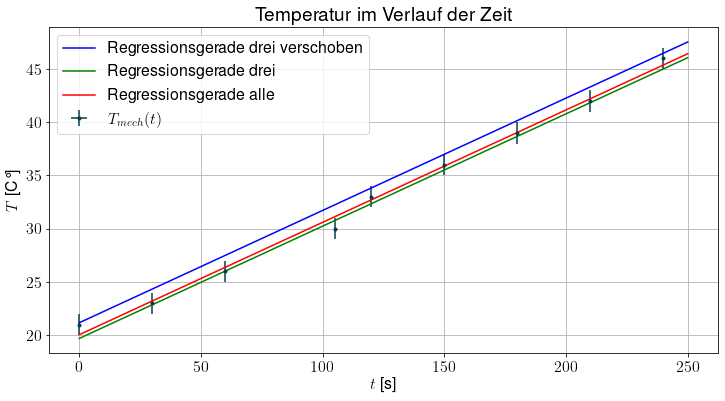

In [17]:
fig, ax = plt.subplots(figsize=(12,6))
#ax.tick_params(axis='both', which='major', labelsize=18)
#ax.tick_params(axis='both', which='minor', labelsize=16)

#ax.plot(x, y, color='b', label='label')
#ax.scatter(x, y, color='r', label='label')

x = np.linspace(0, 250, 500)
a, b = bestA(t_e_170_s, temp_e_170_s), bestB(t_e_170_s, temp_e_170_s)

ax.errorbar(t_e_170, temp_e_170, xerr=t_m_f, yerr=temp_m_f, fmt='.', color='#073b4c', label=r'$T_{mech}(t)$')

ax.plot(x, b*(x+14)+a, color='b', label='Regressionsgerade drei verschoben')
ax.plot(x, b*(x)+a, color='g', label='Regressionsgerade drei')

a2, b2 = bestA(t_e_170, temp_e_170), bestB(t_e_170, temp_e_170)
ax.plot(x, b2*(x)+a2, color='r', label='Regressionsgerade alle')

ax.set(xlabel=r'$t$ [s]', ylabel=r'$T$ [C°]', title=r'Temperatur im Verlauf der Zeit')
ax.legend()
ax.grid()

fig.savefig("Tel170.svg")

print((b*(max(x)+14)+a)-(b2*(max(x))+a2))

-0.5911111111111111


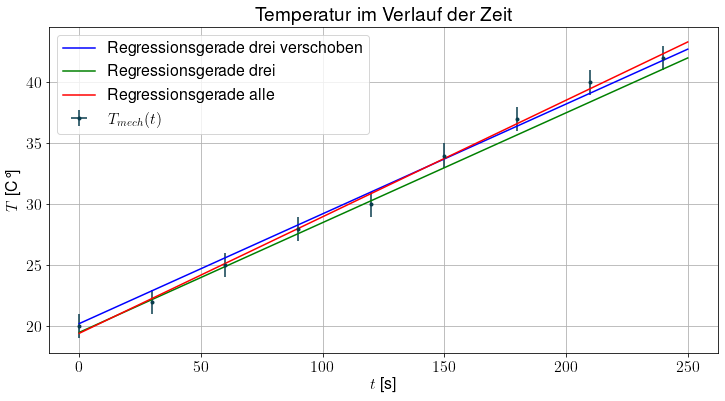

In [18]:
fig, ax = plt.subplots(figsize=(12,6))
#ax.tick_params(axis='both', which='major', labelsize=18)
#ax.tick_params(axis='both', which='minor', labelsize=16)

#ax.plot(x, y, color='b', label='label')
#ax.scatter(x, y, color='r', label='label')

x = np.linspace(0, 250, 500)
a, b = bestA(t_e_190_s, temp_e_190_s), bestB(t_e_190_s, temp_e_190_s)

ax.errorbar(t_e_190, temp_e_190, xerr=t_m_f, yerr=temp_m_f, fmt='.', color='#073b4c', label=r'$T_{mech}(t)$')

ax.plot(x, b*(x+8)+a, color='b', label='Regressionsgerade drei verschoben')
ax.plot(x, b*(x)+a, color='g', label='Regressionsgerade drei')

a2, b2 = bestA(t_e_190, temp_e_190), bestB(t_e_190, temp_e_190)
ax.plot(x, b2*(x)+a2, color='r', label='Regressionsgerade alle')

ax.set(xlabel=r'$t$ [s]', ylabel=r'$T$ [C°]', title=r'Temperatur im Verlauf der Zeit')
ax.legend()
ax.grid()

fig.savefig("Tel190.svg")

print((b*(max(x)+8)+a)-(b2*(max(x))+a2))

1.1177777777777749


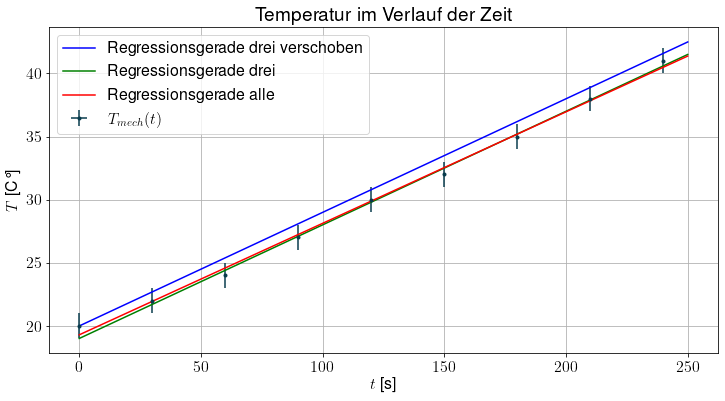

In [19]:
fig, ax = plt.subplots(figsize=(12,6))
#ax.tick_params(axis='both', which='major', labelsize=18)
#ax.tick_params(axis='both', which='minor', labelsize=16)

#ax.plot(x, y, color='b', label='label')
#ax.scatter(x, y, color='r', label='label')

x = np.linspace(0, 250, 500)
a, b = bestA(t_e_210_s, temp_e_210_s), bestB(t_e_210_s, temp_e_210_s)

ax.errorbar(t_e_210, temp_e_210, xerr=t_m_f, yerr=temp_m_f, fmt='.', color='#073b4c', label=r'$T_{mech}(t)$')

ax.plot(x, b*(x+11)+a, color='b', label='Regressionsgerade drei verschoben')
ax.plot(x, b*(x)+a, color='g', label='Regressionsgerade drei')

a2, b2 = bestA(t_e_210, temp_e_210), bestB(t_e_210, temp_e_210)
ax.plot(x, b2*(x)+a2, color='r', label='Regressionsgerade alle')

ax.set(xlabel=r'$t$ [s]', ylabel=r'$T$ [C°]', title=r'Temperatur im Verlauf der Zeit')
ax.legend()
ax.grid()

fig.savefig("Tel210.svg")

print((b*(max(x)+11)+a)-(b2*(max(x))+a2))

1.5411111111111069


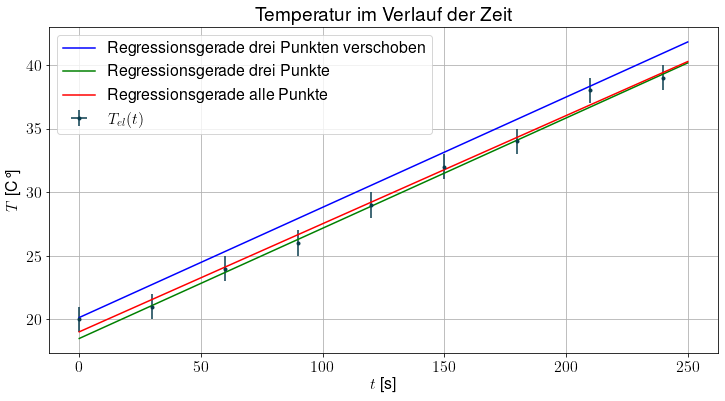

In [20]:
fig, ax = plt.subplots(figsize=(12,6))
#ax.tick_params(axis='both', which='major', labelsize=18)
#ax.tick_params(axis='both', which='minor', labelsize=16)

#ax.plot(x, y, color='b', label='label')
#ax.scatter(x, y, color='r', label='label')

x = np.linspace(0, 250, 500)
a, b = bestA(t_e_230_s, temp_e_230_s), bestB(t_e_230_s, temp_e_230_s)

ax.errorbar(t_e_230, temp_e_230, xerr=t_m_f, yerr=temp_m_f, fmt='.', color='#073b4c', label=r'$T_{el}(t)$')

ax.plot(x, b*(x+19)+a, color='b', label='Regressionsgerade drei Punkten verschoben ')
ax.plot(x, b*(x)+a, color='g', label='Regressionsgerade drei Punkte')

a2, b2 = bestA(t_e_230, temp_e_230), bestB(t_e_230, temp_e_230)
ax.plot(x, b2*(x)+a2, color='r', label='Regressionsgerade alle Punkte')

ax.set(xlabel=r'$t$ [s]', ylabel=r'$T$ [C°]', title=r'Temperatur im Verlauf der Zeit')
ax.legend()
ax.grid()

fig.savefig("Tel230.svg")

print((b*(max(x)+19)+a)-(b2*(max(x))+a2))

In [22]:
# temp_m_f t_m_f
m_e = np.array([170, 210, 230])/1000
m_e_f = 0.001
temp_e_diff = np.array([(max(temp_e_190)-min(temp_e_190)+1.11), (max(temp_e_210)-min(temp_e_210)+1.12),
                        (max(temp_e_230)-min(temp_e_230)+1.54)])

temp_e_diff_f = 1.0
t = 240
t_f = 1
spannung = 30
spannung_f = 0.5
strom = 2.85
strom_f = 0.05
w_k_e = (spannung*strom*t)/(temp_e_diff*m_e)


print(w_k_e)
print(stu(w_k_e))

[5223.1017894  4417.46318781 4343.59256594]
281.66636087708287


In [ ]:
vertraeglichkeit(4661, 5125, 282, 142)

In [ ]:
def vertraeglichkeit(am_1, am_2, stu_1, stu_2):
    return (np.abs(am_1-am_2)/(np.sqrt((stu_1**2)+(stu_2**2))))

print(vertraeglichkeit(4661, 5125, 282, 142))